# Libraries

In [1]:
from __future__ import division, print_function
from importlib import import_module

import os
import sys
import numpy as np
from numpy.polynomial.polynomial import polyval
import scipy.io as sio
import matplotlib.pyplot as plt
import math
from math import pi

# Import tqdm (progress bar)
try:
    library = import_module('tqdm')
except:
    print(sys.exc_info())
else:
    globals()['tqdm'] = library

from lib import *

from IPython.display import clear_output
%matplotlib inline

# Directories

In [2]:
# Data files
name_folder = 'matlab5'
name_export = 'matlab5_export'

# Directory
dir_main = os.getcwd()
dir_folder = os.path.join(dir_main, 'data', name_folder)

# List files
mat_list = os.listdir(dir_folder)

# Set-up

## Data processing values

In [3]:
# Parameters (setup)
asy = 0.1
steps = 20

## Data storage

In [4]:
# Data dictionary (Omega = numerical frequency, others are predictions)
data = {'gain': [],
        'Omega': [],
        'Gauss': [],
        '1': [],
        '2': [],
        '3': [],
        '4': [],
        '5': []
       }

coeffs = {} # key is the gain value

# Parameters (fixed)
dir_data0 = os.path.join(dir_folder, mat_list[0])
dict_mat0 = sio.loadmat(dir_data0, appendmat=False)

par = {'N': dict_mat0['N'][0,0],
       'g': dict_mat0['g'][0,0],
       'T': dict_mat0['T'][0,0],
       'omega0': dict_mat0['omega0'][0,0],
       'a': 1.0
       }

# Model parameters
N_x = par['N']
N_tau = N_x**2
w0 = par['omega0']
g = par['g']
a = 1.0
T = par['T']

# Import data

In [5]:
# Progress bar
try:
    total = (1+1+5)*len(mat_list)
    pbar = tqdm.tqdm(total=total)
    up_num = 1            
except:
    print('tqmb package missing! No progress bar defined.')
    is_bar = False
else:
    is_bar = True
    
for k in range(len(mat_list)):
    dir_mat = os.path.join(dir_folder, mat_list[k])
    dict_mat = sio.loadmat(dir_mat)
    
    coeff0 = {}
    
    # Solution
    sol = {}
    sol['t'] = np.reshape(dict_mat['t'], -1)
    sol['y'] = dict_mat['y']
    sol['yp'] = dict_mat['yp']
    sol['gain'] = dict_mat['gain'][0,0]
    
    
    # PROCESS DATA
    par['gain'] = sol['gain']
    
    # Compute global frequency
    arr_omega = asylib.weight_avg(sol['t'], sol['yp'], asy)
    Omega = np.sum(arr_omega) / arr_omega.size
    
    # Store
    data['gain'].append(sol['gain'])
    data['Omega'].append(Omega)
    
    # Update progress bar (pbar):
    if is_bar:
        pbar.update(up_num)
    
    # Get array of asymptotic phases:
    arr_lin = Omega*sol['t']
    arr_lin = arr_lin[:,None]

    arr_diff = sol['y'] - arr_lin
    
    # Asymptotic phases and indices (used to compute prediction values)
    asy_phases = asylib.weight_avg(sol['t'], arr_diff, asy)
    asy_inds = np.arange(asy_phases.size)/asy_phases.size
    
    # GAUSSIAN PREDICTION
    
    # Compute asymptotic phase variance
    asy_diffs = asy_phases[:,None] - asy_phases
    sigma2 = np.var(asy_diffs)
    sigma = np.sqrt(sigma2)
    
    # Gaussian prediction
    fun_gauss = lambda u: w0 + g*a*funlib.R_sum_gauss(u, N_tau, N_x, par, sigma) - u
    Omega_gauss = rootlib.find_root(fun_gauss, w0, w0-g, w0+g, steps=steps)
    
    # Update progress bar (pbar):
    if is_bar:
        pbar.update(up_num)
        
    # Store
    data['Gauss'].append(Omega_gauss)
    coeff0['sigma2'] = sigma2
    
    # POLYNOMIAL PREDICTIONS
    
    for n in range(1,6):
        
        # Obtain coefficients
        b = np.polyfit(asy_inds, asy_phases, n)
        b = np.flip(b, axis=-1)
    
        phi_fun = lambda X: polyval(X, b)
        fun_poly = lambda u: w0 + g*a*funlib.R_sum(u, N_tau, N_x, par, phi_fun) - u
        Omega_poly = rootlib.find_root(fun_poly, w0, w0-g, w0+g, steps=steps)
    
        # Store
        data[str(n)].append(Omega_poly)
        coeff0[str(n)] = b.copy()
        
        # Update progress bar (pbar):
        if is_bar:
            pbar.update(up_num)

100%|██████████████████████████████████████████| 42/42 [01:49<00:00,  2.61s/it]

# Plot

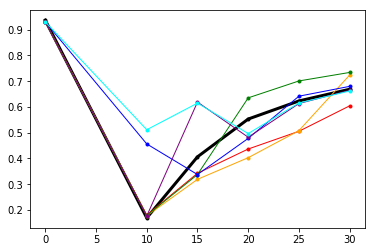

In [6]:
fig, ax = plt.subplots(1,1)

# Figure options
pltopts = {'linestyle': '-',
           'linewidth': 1.0,
           'marker': '.',
          }

pltopts2 = {'linestyle': '-',
            'linewidth': 3.0,
            'marker': '.',
           }
ax.plot(data['gain'], data['Omega'], color='black', **pltopts2)
ax.plot(data['gain'], data['Gauss'], color='red', **pltopts)
ax.plot(data['gain'], data['1'], color='orange', **pltopts)
ax.plot(data['gain'], data['2'], color='green', **pltopts)
ax.plot(data['gain'], data['3'], color='blue', **pltopts)
ax.plot(data['gain'], data['4'], color='purple', **pltopts)
ax.plot(data['gain'], data['5'], color='cyan', **pltopts)

# Export arrays

In [7]:
# .mat file
ex_mat = {}
ex_mat['gain'] = np.array(data['gain'])
ex_mat['Omega'] = np.array(data['Omega'])
ex_mat['Gauss'] = np.array(data['Gauss'])
ex_mat['1'] = np.array(data['1'])
ex_mat['2'] = np.array(data['2'])
ex_mat['3'] = np.array(data['3'])
ex_mat['4'] = np.array(data['4'])
ex_mat['5'] = np.array(data['5'])

# Parameters
ex_mat['N'] = par['N']
ex_mat['w0'] = par['omega0']
ex_mat['g'] = par['g']
ex_mat['a'] = 1.0
ex_mat['T'] = par['T']

# Export
dir_export = os.path.join(dir_main, 'data', 'export', name_export)
sio.savemat(dir_export, ex_mat)